# Sentiment Analysis - NLP toolkit


### Task description

Here, the goal is to predict sentiment -- the emotional intent behind a statement -- from text. For example, the sentence: "*This movie was terrible!"* has a negative sentiment, whereas "*loved this cinematic masterpiece*" has a positive sentiment.

To simplify the task, consider sentiment binary: labels of `1` indicate a sentence has a positive sentiment, and labels of `0` indicate that the sentence has a negative sentiment.

### Dataset

The dataset is split across three files, representing three different sources -- Amazon, Yelp and IMDB. Your task is to build a sentiment analysis model using both the Yelp and IMDB data as your training-set, and test the performance of your model on the Amazon data.

In [1]:
import os
print(os.listdir("../input"))

['amazon_cells_labelled.txt', 'readme.txt', 'yelp_labelled.txt', 'imdb_labelled.txt']


In [2]:
!head "../input/amazon_cells_labelled.txt"

So there is no way for me to plug it in here in the US unless I go by a converter.	0
Good case, Excellent value.	1
Great for the jawbone.	1
Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!	0
The mic is great.	1
I have to jiggle the plug to get it to line up right to get decent volume.	0
If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.	0
If you are Razr owner...you must have this!	1
Needless to say, I wasted my money.	0
What a waste of money and time!.	0


In [3]:
# import libraries
import os
import string
import warnings
import re
import time

import pandas as pd # for importing files as pandas dataframe
pd.set_option('display.max_colwidth', 50) # display setting

import numpy as np # for numerical computing

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm

#pip install wordcloud
from wordcloud import WordCloud
import operator

import matplotlib.pyplot as plt # plotting functions
%matplotlib inline

/Users/piyushm/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Tasks
### 1. Read and concatenate data into test and train sets.

In [10]:
# 1a. Import csv files as pandas data frames

# training data files
yelp = pd.read_csv('../input/yelp_labelled.txt', sep='\t', names=['body_text','class'])
imdb = pd.read_csv('../input/imdb_labelled.txt', sep='\t', names=['body_text', 'class'])

# test data file
amazon = pd.read_csv('../input/amazon_cells_labelled.txt', sep='\t', names=['body_text','class'])

In [11]:
#1b. Explore datasets and sanity checks

# check types dataset columns
print (pd.concat([yelp.dtypes, imdb.dtypes, amazon.dtypes], axis=1))
print("\n")

# check shape of the datasets
print (yelp.shape, imdb.shape, amazon.shape)
print("\n")

# check labels distribution and class balance
pd.concat([pd.crosstab(yelp['class'], columns="yelp_count"), 
          pd.crosstab(imdb['class'], columns="imdb_count"),
          
          pd.crosstab(amazon['class'], columns="amazon_count")], axis=1)

# confirm that there's no missing data
pd.concat([yelp.isnull().sum(),
          imdb.isnull().sum(),
          
          amazon.isnull().sum()], axis=1)

# check first 2 rows
pd.concat([yelp.head(n=2),
          imdb.head(n=2),
          
          amazon.head(n=2)], axis=1)

                0       1       2
body_text  object  object  object
class       int64   int64   int64


((1000, 2), (748, 2), (1000, 2))




,body_text,class,body_text,class,body_text,class
0,Wow... Loved this place.,1,"A very, very, very slow-moving, aimless movie ...",0,So there is no way for me to plug it in here i...,0
1,Crust is not good.,0,Not sure who was more lost - the flat characte...,0,"Good case, Excellent value.",1


In [12]:
#1c. Concatenate dataframes into train and test sets
# trainset
trainset = pd.concat([yelp, imdb], axis=0)
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1748 entries, 0 to 747
Data columns (total 2 columns):
body_text    1748 non-null object
class        1748 non-null int64
dtypes: int64(1), object(1)
memory usage: 41.0+ KB


In [13]:
# testset
testset = amazon.copy()
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
body_text    1000 non-null object
class        1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.7+ KB


In [14]:
# make copies of dataframes, I'll work on the copies of orginal set
train_df = trainset.copy()
test_df = testset.copy()

### 2. Prepare the data for input into your model.

####  Data preparation steps in sentiment analysis -

Below are some of the NLP good practices that I follow and recommend our team to do so. For this excercise, I'll use wide range of functions and builtin libraries to action these steps, 

Steps i to iv will be done through a single function - clean_text()

i. Remove Punctuation - 
- punctuation words does not help defining the context, best to remove any punctuations marks, numerical values, links, urls and hashtags

ii. Tokenize - 
- telling the model what to look at

iii. Remove Stop Words - 
- likewise stopwords too does not help in defining the context, exhaustive stopwords search including language, location, time and numerals is key for performance gain

iv. Stemming vs Lemmatizing - 
Stemming - 
 - reduce inflectional or derived forms of a word to a common base form, this improves feature importance, basically chopping of the end of the word to leave only the base of the word, there are many stemmers included in the nltk library like porter, snowball, lancaster and regex-based. I recommend most popular -  porter stemmer

Lemmatizing - 
-grouping together the inflected words to a single term identified by the word's lemma. To remove inflectional endings from the words to return to the dictionary form of the word. 
- just to explain, stemming and lemming are pretty much the same, stemming crudely chops of the end of the word using heuristics without taking context into account. 

- Lemmatizing is generally more accurate as it uses context to create groups of words with similar meanings based on context. But its slower than stemming. Depending on the situation and computing resources stemming can be chosen over lemmatizing but I recommend using Lemmatizing all the time. I recommend and will use WordNetLemmatizer, the most popular lemmatizer.


v. Vectorizing - converting text to numeric form 
- encoding text as integers to create feature vectors so that model can understand the text. creting document term matrix.
- generally speaking count vectorization is more common, however other better variations like N-grams and TF-IDF (term frequency - inverse document frequency) can be used. TF-IDF Creates a document term matrix where the columns represent single unique terms (unigrams) but the cell represents a weighting meant to represent how important a word is to a document.
- From past experience, TF-IDF gave better performance over count or N-grams methods. Since, its weighted and takes into account word to document relationship, its more robust. Weight = tf(i,j) x log(N/df(i)). tf(i,j) = no. of times a word i occurs in document j divided by total no. of words in j; df(i) = no. of docs containing word i, N=total no. of documents
- For this exercise I am using TF-IDF at default settings.

Vectorizing test dataset
- since the training and test data sets in the exercise comes from diffrent sources with different numbers of features, its very important to vectorize the test data using training data fit. 

vi. Model development - for this section of the excersize I am using powerful and efficient 'Pipeline' utilities from sklearn library
- Select Classifiers - Considering problem in hand and dataset size, I am trying five base classifiers -  Logistic Regression (LR), SGD (LR with Stochastic Gradient Descent), Random Forest (RF), Gradient Boosting (GB) and Support Vector Machines (SVM). 
- Construct Pipelines
- Set grid parameters
- Construct grid searches for cross-validation
- List piplines for iteration
- Fit model, evaluate performance and optimise hyper-parameters to select the best model

vii. Benchmarking classifier performance, model evaluation and selecting best model
- Benchmarking results
- Criteria for model selection - Accuracy, Overfitting, Underfitting, Fit and Predict time,  Balanced results

viii. Next steps for experimentation for further optimising best models performance.

In [17]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

# Function to implement data preparation steps i to iv
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    tokens = [token for token in tokens if len(token) > 1]
    #tokens = [token for token in tokens if not token.isnumeric()]
    tokens = [token for token in tokens if token.isalpha()]

    #text = " ".join([ps.stem(token) for token in tokens if token not in stopwords])
    text = " ".join([wn.lemmatize(token) for token in tokens if token not in stopwords])
    return text

In [18]:

# training data
train_df['cleaned_text'] = train_df['body_text'].apply(lambda x: clean_text(x))
train_df.head()

,body_text,class,cleaned_text
0,Wow... Loved this place.,1,wow loved place
1,Crust is not good.,0,crust good
2,Not tasty and the texture was just nasty.,0,tasty texture nasty
3,Stopped by during the late May bank holiday of...,1,stopped late may bank holiday rick steve recom...
4,The selection on the menu was great and so wer...,1,selection menu great price


In [19]:
#Q2 soln.
# test data
test_df['cleaned_text'] = test_df['body_text'].apply(lambda x: clean_text(x))
test_df.head()

,body_text,class,cleaned_text
0,So there is no way for me to plug it in here i...,0,way plug u unless go converter
1,"Good case, Excellent value.",1,good case excellent value
2,Great for the jawbone.,1,great jawbone
3,Tied to charger for conversations lasting more...,0,tied charger conversation lasting minutesmajor...
4,The mic is great.,1,mic great


#### 2a: Finding the ten most frequent words in the training set.

In [20]:

# calculate word frequencies
word_freq = WordCloud().process_text( ' '.join(train_df['cleaned_text']) ) 
top10 = sorted(word_freq.items(), key=operator.itemgetter(1), reverse=True)[:10]
top10

[(u'movie', 208),
 (u'film', 182),
 (u'good', 151),
 (u'food', 125),
 (u'place', 118),
 (u'great', 110),
 (u'one', 97),
 (u'bad', 85),
 (u'time', 80),
 (u'service', 79)]

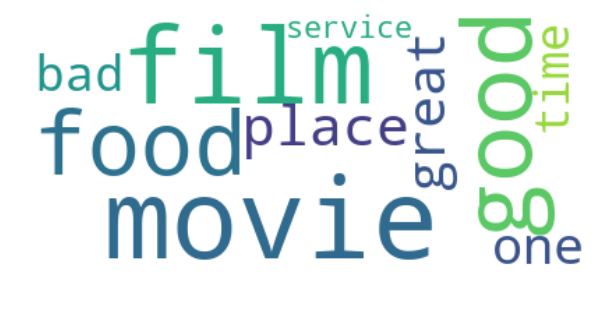

In [21]:

# plot top 10 word frequencies
wordcloud = WordCloud(max_font_size=80, max_words=10, background_color="white").generate_from_frequencies(word_freq)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


### 3. Train your model and justify your choices.

In [22]:

# v. Vectorizing Data: TF-IDF - Using default parameters for this exercise. Vectorisation methods and hyperparameters can be optimised.

# initiate TF-IDF vectorizer
tfidf_vect = TfidfVectorizer()

# fit training data
X_tfidf_fit = tfidf_vect.fit(train_df['cleaned_text'])

# transform training and test data using fit object
X_train = X_tfidf_fit.transform(train_df['cleaned_text'])
X_test = X_tfidf_fit.transform(test_df['cleaned_text'])

y_train = train_df['class']
y_test = test_df['class']

# numbers of features in train and test data must be same
print(X_train.shape)
print(X_test.shape)

print(tfidf_vect.get_feature_names()[0:50])

(1748, 3909)
(1000, 3909)
[u'aailiyah', u'abandoned', u'ability', u'abroad', u'absolute', u'absolutely', u'absolutley', u'abstruse', u'abysmal', u'academy', u'accent', u'accessible', u'accident', u'acclaimed', u'accolade', u'accommodation', u'accomodate', u'accordingly', u'accountant', u'accurate', u'accurately', u'accused', u'ache', u'achievement', u'achille', u'ackerman', u'acknowledged', u'across', u'act', u'acted', u'acting', u'actingeven', u'actingwise', u'action', u'actor', u'actorsan', u'actress', u'actual', u'actually', u'adam', u'adaptation', u'add', u'added', u'addition', u'admins', u'admiration', u'admitted', u'adorable', u'adorablehis', u'adorablethe']


In [23]:

# Vi.a Construct pipelines - classifiers : LR, SGD, RF, GB, SVM
#Considering problem in-hand and dataset size, I am trying five base classifiers to binary classification optimisers -  
#Logistic Regression (LR), SGD (LR with Stochastic Gradient Descent), Random Forest (RF), Gradient Boosting (GB) and Support Vector Machines (SVM). 

# LR - Logistic Regression
pipeline_lr = Pipeline([
    ('clf', LogisticRegression(random_state=42))])

# SGD - Linear classifiers with Stochastic Gradient Descent training.
pipeline_sgd = Pipeline([
     ('clf', SGDClassifier(random_state=42))])

# RF - Random Forest
pipeline_rf = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))])

# gb - Gradient Boosting
pipeline_gb = Pipeline([
    ('clf', GradientBoostingClassifier(random_state=42))])

# SVM - Support Vector Machine
pipeline_svm = Pipeline([
    ('clf', svm.SVC(random_state=42))])


In [24]:

# Vi.b set grid parameters - 
# grid parameters that are set here are found to be key in previous experimentations with these classifiers and 
# the range of values chosen here would cover the wide search space for optimal performance

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
                   'clf__C': [0.01, 0.1, 0.5, 1],
                   'clf__solver': ['liblinear']}]

grid_params_sgd = [{'clf__penalty': ['l1', 'l2', 'elasticnet'],
                   'clf__alpha': [0.0001, 0.001, 0.01],
                   'clf__max_iter': [3, 4, 5, 6, 7],
                   'clf__tol': [None]}] 

grid_params_rf = [{'clf__n_estimators': [10, 50, 100, 150],
                   'clf__max_depth': [7, 10, 30, 60, 90, None]}]
                 
grid_params_gb = [{'clf__n_estimators': [10, 50, 100, 150],
                   'clf__max_depth': [7, 10, 11, 15],
                   'clf__learning_rate': [0.01, 0.1]}]

grid_params_svm = [{'clf__kernel': ['linear', 'poly', 'sigmoid', 'rbf'], 
                    'clf__C': [0.01, 0.1, 0.5, 1],
                    'clf__probability' : [True]}]


In [25]:

# Vi.c Construct grid searches for cross-validation

gs_lr = GridSearchCV(estimator = pipeline_lr,
                     param_grid = grid_params_lr,
                     scoring = 'accuracy',
                     cv = 5, 
                     refit = True, n_jobs = -1,
                     return_train_score = True)

gs_sgd = GridSearchCV(estimator = pipeline_sgd,
                     param_grid = grid_params_sgd,
                     scoring = 'accuracy',
                     cv = 5,
                     refit = True, n_jobs = -1,
                     return_train_score = True)

gs_rf = GridSearchCV(estimator = pipeline_rf,
                     param_grid = grid_params_rf,
                     scoring = 'accuracy',
                     cv = 5,
                     refit = True, n_jobs = -1,
                     return_train_score = True)

gs_gb = GridSearchCV(estimator = pipeline_gb,
                     param_grid = grid_params_gb,
                     scoring = 'accuracy',
                     cv = 5,
                     refit = True, n_jobs = -1,
                     return_train_score = True)

gs_svm = GridSearchCV(estimator = pipeline_svm,
                      param_grid = grid_params_svm,
                      scoring = 'accuracy',
                      cv = 5, 
                      refit = True, n_jobs = -1,
                      return_train_score = True)


In [26]:

# Vi.d list piplines for iteration - we can chose number of models to optimise
grids = [gs_lr, gs_sgd, gs_rf, gs_gb, gs_svm]
         
# Dictionary of pipelines and classifiers for referencing later
grid_dict = {0: 'Logistic Regression', 1: 'SGD', 
             2: 'Random Forest', 3: 'Gradient Boosting',
            4: 'SVM'}


### 4. Evaluating model using metrics and reasoning of choices made

- Fit model, evaluate performance and optimise hyper-parameters to select the best model

vii. Benchmarking classifier performance, model evaluation and selecting best model
- Benchmarking results
- Criteria for model selection - Accuracy, Overfitting, Underfitting, Fit and Predict time,  Balanced results

viii. Next steps for experimentation for further optimising best models performance.

In [27]:
# vi.e Fit model, evaluate performance and optimise hyper-parameters to select the best model
warnings.filterwarnings('ignore')

print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''

for idx, gs in enumerate(grids):

    print('\nClassifier: %s' % grid_dict[idx])
    
    # Fit grid search
    start = time.time()
    gs.fit(X_train, y_train)
    end = time.time()
    fit_time = (end - start)
    
    # Best params
    print('Best params: %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    
    # Predict on test data with best params
    start = time.time()
    y_pred = gs.predict(X_test)
    end = time.time()
    predict_time = (end - start)

    #y_pred_prob = gs.predict_proba(X_test)
    
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    
    # Test data performance measures of model with best params
    precision, recall, fscore, support = score(y_test, y_pred, pos_label=1, average='binary')
    print('Test set evaluation metrics of model with best params: ')
    print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {} / AUROC: {}'.format(round(precision, 3),
                                                                          round(recall, 3),
                                                                          round(fscore, 3),
                                                                          round(accuracy_score(y_test, y_pred), 3),
                                                                          round(roc_auc_score(y_test, y_pred), 2)))
    print('Fit time: {} / Predict time: {}'.format(
        round(fit_time, 3), round(predict_time, 3)))
    
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
        
print('\n Classifier with best test set accuracy: %s' % grid_dict[best_clf])


Performing model optimizations...

Classifier: Logistic Regression
Best params: {'clf__penalty': 'l2', 'clf__C': 1, 'clf__solver': 'liblinear'}
Best training accuracy: 0.771
Test set accuracy score for best params: 0.766 
Test set evaluation metrics of model with best params: 
Precision: 0.785 / Recall: 0.732 / F1-Score: 0.758 / Accuracy: 0.766 / AUROC: 0.77
Fit time: 0.402 / Predict time: 0.001

Classifier: SGD
Best params: {'clf__penalty': 'l2', 'clf__tol': None, 'clf__max_iter': 6, 'clf__alpha': 0.001}
Best training accuracy: 0.779
Test set accuracy score for best params: 0.762 
Test set evaluation metrics of model with best params: 
Precision: 0.78 / Recall: 0.73 / F1-Score: 0.754 / Accuracy: 0.762 / AUROC: 0.76
Fit time: 1.126 / Predict time: 0.0

Classifier: Random Forest
Best params: {'clf__max_depth': 60, 'clf__n_estimators': 150}
Best training accuracy: 0.752
Test set accuracy score for best params: 0.737 
Test set evaluation metrics of model with best params: 
Precision: 0.82

In [28]:
# explore cross-validation results from best performing model
# pd.DataFrame(best_gs.cv_results_).sort_values('mean_test_score', ascending=False)[0:3]

In [29]:
# Save best grid search pipeline to pickle file
dump_best_gs_file = 'best_gs_pipeline.pkl'
joblib.dump(best_gs, dump_best_gs_file, compress=1)

print('\nSaved %s grid search pipeline of the best model to file: %s' % (grid_dict[best_clf], dump_best_gs_file))


Saved Logistic Regression grid search pipeline of the best model to file: best_gs_pipeline.pkl



vii. Benchmarking results - 

From the benchmarking excercise Logistic Regression came up as the best classifier based on accuracy. 
But its just not enough to make solid decisions. Below are some of the additional critera that I take into account for selecting best models

In addition to base performance metric, 
- I looked at training and test accuracies and established that the model is not overfitting or underfitting.
- fit and predict time, when dealing with production level model, time is key, and for real-time streaming applications predict time is crucial for business to process incoming streams quickly.
from the benchmarking we notice that Logistic Regression is super efficient in terms of predict time.
Fit time for SGD is better than LR but we should not worry too much about the fit time as its one time process whereas predict time can be very important.
- precision, recall, auroc - the LR model is balances sensitivity and specificity.

Outcome:   the best classifier is low-variance/low-bias Regularised Logistic Regression model

Best Model Specs:  Best params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
    
Best training accuracy: 0.771
Test set accuracy score for best params: 0.766 

Evaluation metrics of model with best params:  Precision: 0.785 / Recall: 0.732 / F1-Score: 0.758 / Accuracy: 0.766 / AUROC: 0.77
             
Fit time: 0.402 / Predict time: 0.001
    


viii. Next steps for further optimisation steps:  

The analysis and approach presented here represents the example of an optimal approach to sentiment analysis using the NLP best practices and past experiences.
Below are some of the steps I would do next to optimise the model development further
- model can be tested for additional hyper-parameters with extended search space
- try other vectorisation methods - counts, n-grams
- optimise vectorisation methods and hyper-parameters - vect__max_df, vect__ngram_range, tfidf__use_idf, tfidf__norm etc..

- investigate where our model failed to make correct predictions. Since we are using different review sources we might be missing out on domain specific key words
- feature engineering - create new features and transformations to boost performance example, word length, percent of punctuation etc..


